In [1]:
import numpy as np
import nltk
import pandas as pd
import collections
from absl import logging
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount("/content/drive/")
df = pd.read_csv("/content/drive/My Drive/NLP summer Internship/Cleanned_Complaints.csv")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [3]:
# Load pretrained model - google universal sentence encoder
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
model = hub.load(module_url)
def embed(input):
  return model(input)

In [4]:
# Seperate out Wellsfargo testset, remove null
df_wells=df[df["Company"]=="WELLS FARGO & COMPANY"]
credit_unions=["EQUIFAX, INC.","TRANSUNION INTERMEDIATE HOLDINGS, INC."]
banks=["CITIBANK, N.A.","BANK OF AMERICA, NATIONAL ASSOCIATION","JPMORGAN CHASE & CO.","U.S. BANCORP"]
mortgages=["Ocwen Financial Corporation","NATIONSTAR MORTGAGE"]
df_cu=df[df["Company"].isin(credit_unions)]
df_banks=df[df["Company"].isin(banks)]
df_mortgages=df[df["Company"].isin(mortgages)]
df_cu=df_cu.dropna()
df_banks=df_banks.dropna()
df_mortgages=df_mortgages.dropna()

In [5]:
# Get corpus and check size
cu_complaint=df_cu["Complaint_reduced"]
banks_complaint=df_banks["Complaint_reduced"]
mortgages_complaint=df_mortgages["Complaint_reduced"]
wells_complaint=df_wells["Complaint_reduced"]
print(len(cu_complaint),len(banks_complaint),len(mortgages_complaint),len(wells_complaint))

116421 58333 11374 17618


In [6]:
# Coding block to calculate pairwise similarity matrix
# This will take 10 minutes to embed and require around 15G memory
print("now embedding wells dataset")
# Embedding wells dataset
wells_embed=embed(wells_complaint)

print("now embedding cu dataset")
# Embedding cu dataset
cu_embed1=embed(cu_complaint[0:60000])
cu_embed2=embed(cu_complaint[60000:])
cu_embed=np.concatenate((cu_embed1,cu_embed2),axis=0)
del(cu_embed1)
del(cu_embed2)
#pairwise similarity
cu_wells_matrix=np.dot(wells_embed,tf.transpose(cu_embed))
#delete embedding and keep similarity matrix to save memory
del(cu_embed)

print("now embedding mortgages dataset")
# Embedding mortgages dataset
mortgages_embed=embed(mortgages_complaint)
#pairwise similarity
mortgages_wells_matrix=np.dot(wells_embed,tf.transpose(mortgages_embed))
#delete embedding and keep similarity matrix to save memory
del(mortgages_embed)

print("now embedding banks dataset")
# Embedding banks dataset
banks_embed1=embed(banks_complaint[0:30000])
banks_embed2=embed(banks_complaint[30000:])
banks_embed=np.concatenate((banks_embed1,banks_embed2),axis=0)
del(banks_embed1)
del(banks_embed2)
banks_wells_matrix=np.dot(wells_embed,tf.transpose(banks_embed))
del(banks_embed)

# Check pairwise similarity matrix shapes
print(cu_wells_matrix.shape,mortgages_wells_matrix.shape,banks_wells_matrix.shape)

now embedding wells dataset
now embedding cu dataset
now embedding mortgages dataset
now embedding banks dataset
(17618, 116421) (17618, 11374) (17618, 58333)


Approach 2a Similarity score with top N closeset sentence from vendor dataset

In [9]:
n_similarity=10 #Do not use n larger than 10 to save memory
# Compute pairwise cosine similarity and find largest n scores' average
cu_wells_top_similarity=np.sum(np.partition(cu_wells_matrix, -n_similarity)[:,-n_similarity:],axis=1)/n_similarity
mortgages_wells_top_similarity=np.sum(np.partition(mortgages_wells_matrix, -n_similarity)[:,-n_similarity:],axis=1)/n_similarity
banks_wells_top_similarity=np.sum(np.partition(banks_wells_matrix, -n_similarity)[:,-n_similarity:],axis=1)/n_similarity
# Check shape, the shape should be (wells_fargo.shape[0],)
print(cu_wells_top_similarity.shape,mortgages_wells_top_similarity.shape,banks_wells_top_similarity.shape)

(17618,) (17618,) (17618,)


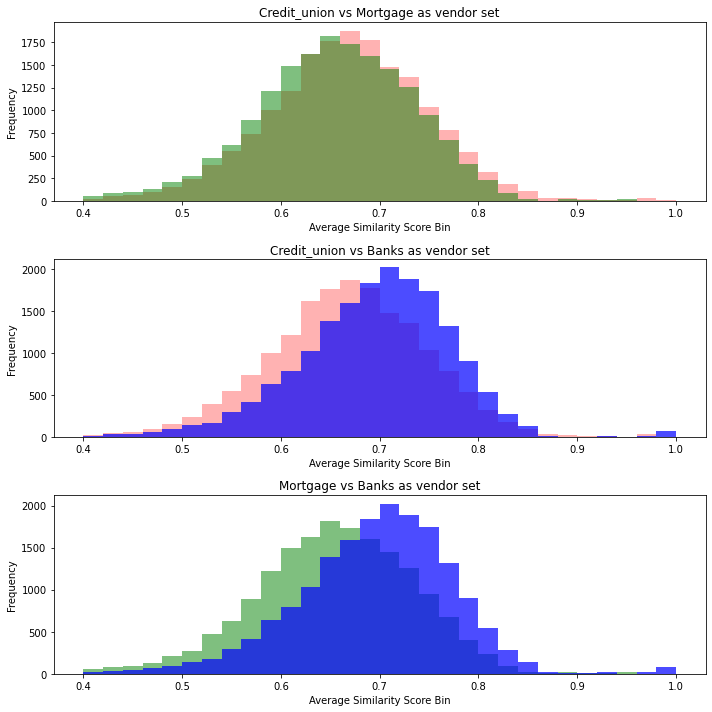

In [10]:
# Plot result distribution
fig, ax = plt.subplots(nrows=3, ncols=1,figsize=(10,10))
ax[0].set_title("Credit_union vs Mortgage as vendor set")
ax[0].set_xlabel("Average Similarity Score Bin")
ax[0].set_ylabel("Frequency")
ax[0].hist(cu_wells_top_similarity,alpha=0.3,bins=30,range=(0.4,1),color="red")
ax[0].hist(mortgages_wells_top_similarity,alpha=0.5,bins=30,range=(0.4,1),color="green")

ax[1].set_title("Credit_union vs Banks as vendor set")
ax[1].set_xlabel("Average Similarity Score Bin")
ax[1].set_ylabel("Frequency")
ax[1].hist(cu_wells_top_similarity,alpha=0.3,bins=30,range=(0.4,1),color="red")
ax[1].hist(banks_wells_top_similarity,alpha=0.7,bins=30,range=(0.4,1),color="blue")

ax[2].set_title("Mortgage vs Banks as vendor set")
ax[2].set_xlabel("Average Similarity Score Bin")
ax[2].set_ylabel("Frequency")
ax[2].hist(mortgages_wells_top_similarity,alpha=0.5,bins=30,range=(0.4,1),color="green")
ax[2].hist(banks_wells_top_similarity,alpha=0.7,bins=30,range=(0.4,1),color="blue")
plt.tight_layout()
plt.show()

Approach 2b Use define closes meaning sentence as cosine similarity >= some threshold, find number of close meaning sentence as document score


In [11]:
# Nearest neighbours threshold
similarity_threshold=0.95
# Count pairs for each document in Wells fargo set which passed the threshold
cu_wells_threshold_count=np.sum((cu_wells_matrix>=similarity_threshold),axis=1)
mortgages_wells_threshold_count=np.sum((mortgages_wells_matrix>=similarity_threshold),axis=1)
banks_wells_threshold_count=np.sum((banks_wells_matrix>=similarity_threshold),axis=1)

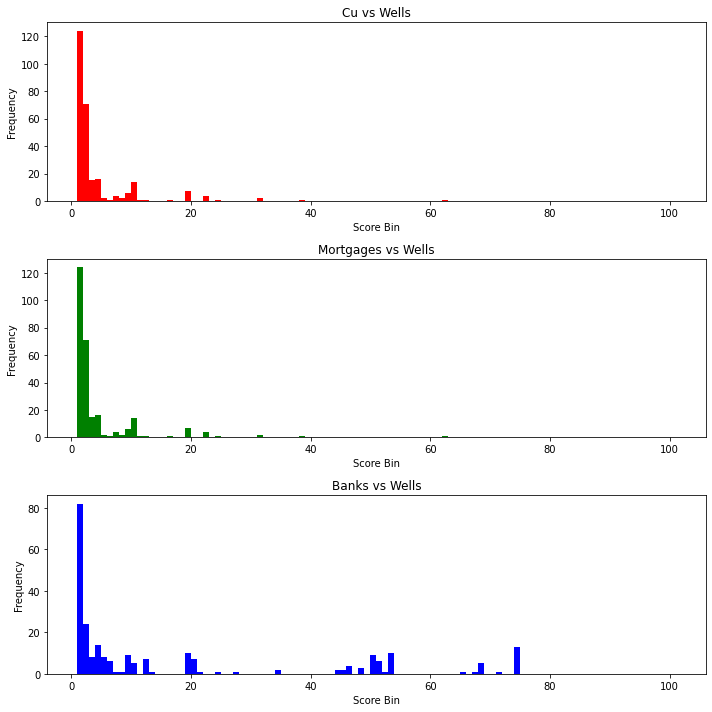

In [12]:
# Plot
fig, ax = plt.subplots(nrows=3, ncols=1,figsize=(10,10))
ax[0].set_title("Cu vs Wells")
ax[0].set_xlabel("Score Bin")
ax[0].set_ylabel("Frequency")
ax[0].hist(cu_wells_threshold_count,alpha=1,bins=100,range=(1,101),color="red")

ax[1].set_title("Mortgages vs Wells")
ax[1].set_xlabel("Score Bin")
ax[1].set_ylabel("Frequency")
ax[1].hist(cu_wells_threshold_count,alpha=1,bins=100,range=(1,101),color="green")

ax[2].set_title("Banks vs Wells")
ax[2].set_xlabel("Score Bin")
ax[2].set_ylabel("Frequency")
ax[2].hist(banks_wells_threshold_count,alpha=1,bins=100,range=(1,101),color="blue")

plt.tight_layout()
plt.show()

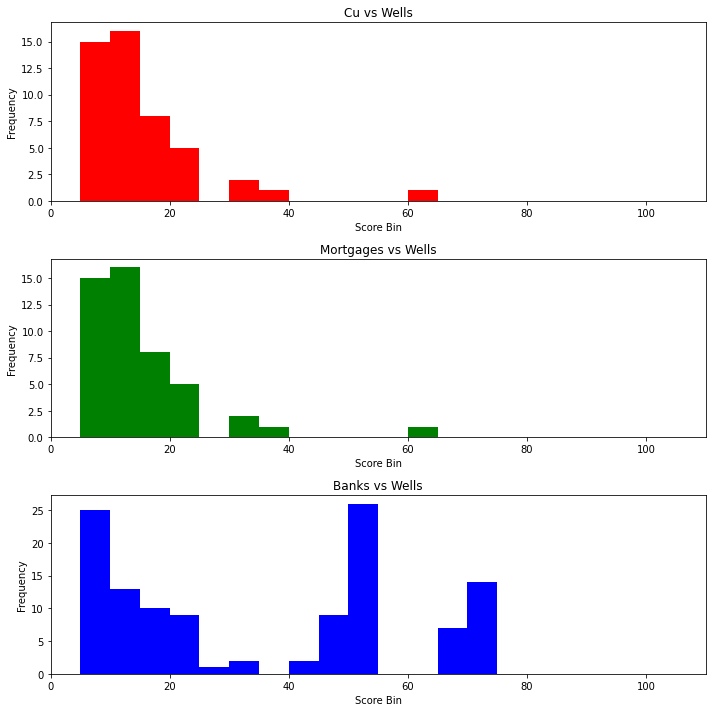

In [13]:
# Plot use different range and bin size
fig, ax = plt.subplots(nrows=3, ncols=1,figsize=(10,10))
ax[0].set_title("Cu vs Wells")
ax[0].set_xlabel("Score Bin")
ax[0].set_ylabel("Frequency")
ax[0].hist(cu_wells_threshold_count,alpha=1,bins=20,range=(5,105),color="red")

ax[1].set_title("Mortgages vs Wells")
ax[1].set_xlabel("Score Bin")
ax[1].set_ylabel("Frequency")
ax[1].hist(cu_wells_threshold_count,alpha=1,bins=20,range=(5,105),color="green")

ax[2].set_title("Banks vs Wells")
ax[2].set_xlabel("Score Bin")
ax[2].set_ylabel("Frequency")
ax[2].hist(banks_wells_threshold_count,alpha=1,bins=20,range=(5,105),color="blue")

plt.tight_layout()
plt.show()